# Asset pricing

## Lucas Tree Model - homework

Prof. Scott Condie

Author: Martina Fraschini

### Load Data

In [1]:
# Import packages
import pandas as pd
import numpy as np

# load time series of personal consumption expenditures
df_pcecc = pd.read_csv("PCECC96.csv", header = 0, encoding="utf-8", sep=",", engine='python')
df_pcecc.index = pd.to_datetime(df_pcecc["DATE"], format="%Y-%m-%d")
df_pcecc = df_pcecc.drop(columns="DATE")

# load time series of GDP deflator
df_gdpdef = pd.read_csv("GDPDEF.csv", header = 0, encoding="utf-8", sep=",", engine='python')
df_gdpdef.index = pd.to_datetime(df_gdpdef["DATE"], format="%Y-%m-%d")
df_gdpdef = df_gdpdef.drop(columns="DATE")

# load time series of returns to the aggregate US stock market
df_will = pd.read_csv("WILL5000INDFC.csv", header = 0, encoding="utf-8", sep=",", engine='python')
df_will.index = pd.to_datetime(df_will["DATE"], format="%Y-%m-%d")
df_will = df_will.drop(columns="DATE")
df_will = df_will[df_will["WILL5000INDFC"] != "."]
df_will["WILL5000INDFC"] = df_will["WILL5000INDFC"].apply(pd.to_numeric)
df_will = df_will.resample('D').asfreq()
df_will = df_will.fillna(method='ffill')
df_will = df_will.resample("QS").asfreq()
#df_will["WILL5000INDFC"] = df_will["WILL5000INDFC"] / df_will["WILL5000INDFC"].shift(1)
df_will["WILL5000"] = (df_will['WILL5000INDFC'] / df_gdpdef["GDPDEF"]) * 100
df_will["WILL5000"] = df_will["WILL5000"] / df_will["WILL5000"].shift(1)
df_will = df_will.drop(columns="WILL5000INDFC")

# load time series of risk-free rate
df_tb3ms = pd.read_csv("TB3MS.csv", header = 0, encoding="utf-8", sep=",", engine='python')
df_tb3ms.index = pd.to_datetime(df_tb3ms["DATE"], format="%Y-%m-%d")
df_tb3ms = df_tb3ms.drop(columns="DATE")
df_tb3ms = df_tb3ms.resample('MS').asfreq()
df_tb3ms = df_tb3ms.fillna(method='ffill')
df_tb3ms = df_tb3ms.resample("QS").asfreq()
df_tb3ms['TB3MS'] = df_tb3ms['TB3MS']/100

# Merge into one DataFrame
df = df_pcecc.merge(df_will,  how='outer', left_index=True, right_index=True)
df = df.merge(df_tb3ms,  how='outer', left_index=True, right_index=True)
df.dropna(axis=0, inplace=True)

### Exercise 1

In [2]:
# import packages
import scipy.optimize as opt

beta = .99

class EstimateGamma1:
    
    def __init__(self, df, beta):
        self.df = df
        self.beta = beta
        
    def funct_toestimate(self, gamma):
        u1 = self.df.PCECC96 ** (-gamma)
        m = self.beta * (u1 / u1.shift(1))
        R = self.df.WILL5000
        
        m = m[1:]
        R = R[1:]
        
        covariance = np.cov(m, R)[0,1]
        expect_m = m.mean()
        expect_R = R.mean()
        
        funct = 1 - covariance - expect_m * expect_R
        
        return funct
        
    def estimate(self, gamma0):
        gamma = opt.broyden1(self.funct_toestimate, gamma0)
        return gamma
    
myclass = EstimateGamma1(df, beta)
gamma_star = myclass.estimate(1.0001)
print("The value of gamma is: ", gamma_star)

The value of gamma is:  1.3433545438695351


### Exercise 2

The value for the coefficient of risk aversion seems reasonable, considering that $\gamma=1$ corrisponds to risk neutrality and for $\gamma>1$ individuals are risk averse. Moreover, empirical studies based on actual behavior of individuals have consistently yielded estimates in the range 1 to 4 for the coefficient of relative risk aversion, with a mean value for $\gamma=2$.

### Exercise 3

In [3]:
beta = .99

class EstimateGamma2:
    
    def __init__(self, df, beta):
        self.df = df
        self.beta = beta
        
    def funct_toestimate(self, gamma):
        u1 = self.df.PCECC96 ** (-gamma)
        m = self.beta * (u1 / u1.shift(1))
        rf = self.df.TB3MS
        
        m = m[1:]
        rf = rf[1:]
        
        expect_m = m.mean()
        expect_rf = rf.mean()
        
        funct = 1 + expect_rf - (1 / expect_m)
        
        return funct
        
    def estimate(self, gamma0):
        gamma = opt.broyden1(self.funct_toestimate, gamma0)
        return gamma
    
myclass = EstimateGamma2(df, beta)
gamma_star = myclass.estimate(1.0001)
print("The value of gamma is: ", gamma_star)

The value of gamma is:  4.818572517122836


The estimate is much bigger than before.

### Exercise 4

In [4]:
class GMM_estimate:
    
    def __init__(self, df):
        self.df = df
    
    def objfun(self, param):
        beta, gamma = param
        
        # define weighting matrix
        W = np.eye(len(param))
        
        moments = np.empty(len(param))
        
        # define first moment
        u1 = self.df.PCECC96 ** (-gamma)
        m = beta * (u1 / u1.shift(1))
        R = self.df.WILL5000
        m = m[1:]
        R = R[1:]
        covariance = np.cov(m, R)[0,1]
        expect_m = m.mean()
        expect_R = R.mean()
        
        moments[0] = 1 - covariance - expect_m * expect_R
        
        # define second moment
        rf = self.df.TB3MS
        rf = rf[1:]
        expect_rf = rf.mean()
        
        moments[1] = 1 + expect_rf - (1 / expect_m)
        
        # define function to minimize
        minfun = moments.T @ W @ moments
        
        return minfun
    
    def estimate(self, param0):
        param = opt.minimize(self.objfun, param0)
        return param
    
myclass = GMM_estimate(df)
param_star = myclass.estimate([.5, 1.001])
print("The value of gamma is: ", param_star.x[1])
print("The value of beta is: ", param_star.x[0])

The value of gamma is:  1.0301044178874472
The value of beta is:  0.9746782584352444


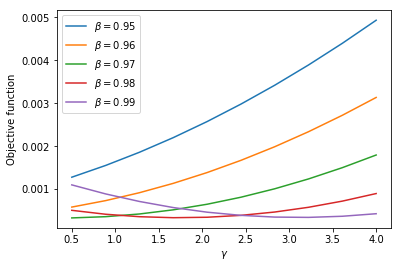

In [6]:
# import packages
from matplotlib import pyplot as plt

# plot for different beta and gamma
beta_vec = np.array([.95, .96, .97, .98, .99])
gamma_vec = np.linspace(.5,4.,10)
for i, beta in enumerate(beta_vec):
    obj = np.empty(len(gamma_vec))
    for j, gamma in enumerate(gamma_vec):
        obj[j] = myclass.objfun([beta, gamma])
    plt.plot(gamma_vec, obj, label=r"$\beta={}$".format(beta))
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel("Objective function")
plt.show()